In [7]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import re
from datetime import timedelta

#### aligning poses and transcripts

In [ ]:
BASE_DIR = "/workspaces/Gesture-Language-Alignment-in-Instructional-Videos/00_videos"
SRT_DIR = os.path.join(BASE_DIR, "transcripts_with_timestamps")
POSE_DIR = os.path.join(BASE_DIR, "pose_outputs")
OUTPUT_DIR = os.path.join(BASE_DIR, "aligned_transcripts")
FPS = 30

def timestamp_to_seconds(ts):
    ts = ts.strip()
    if "," in ts:
        h, m, s_ms = ts.split(":")
        s, ms = s_ms.split(",")
    elif "." in ts:
        h, m, s_ms = ts.split(":")
        s, ms = s_ms.split(".")
    else:
        raise ValueError(f"Unrecognized timestamp format: {ts}")
    return int(h) * 3600 + int(m) * 60 + int(s) + int(ms) / 1000

def parse_srt(srt_path):
    with open(srt_path, "r", encoding="utf-8") as f:
        content = f.read()

    blocks = re.split(r"\n\s*\n", content.strip())
    segments = []

    for block in blocks:
        lines = block.strip().split("\n")
        if len(lines) >= 3:
            timestamp_line = lines[1]
            text = " ".join(lines[2:])
            start_ts, end_ts = re.split(r"\s*-->\s*", timestamp_line)
            segments.append({
                "start_time": timestamp_to_seconds(start_ts),
                "end_time": timestamp_to_seconds(end_ts),
                "text": text
            })

    return segments

def compute_motion(pose_data, joint_idx=16):
    motion = []
    prev = None

    for frame_idx in sorted(pose_data.keys(), key=int):
        keypoints = pose_data[frame_idx]
        if len(keypoints) > joint_idx:
            pt = keypoints[joint_idx]
            if prev:
                dist = np.sqrt((pt["x"] - prev["x"])**2 + (pt["y"] - prev["y"])**2)
                motion.append(dist)
            else:
                motion.append(0)
            prev = pt
        else:
            motion.append(0)
    return motion

def match_transcript_with_pose(base_name):
    srt_path = os.path.join(SRT_DIR, f"{base_name}.srt")
    pose_path = os.path.join(POSE_DIR, f"{base_name}_pose.json")
    output_path = os.path.join(OUTPUT_DIR, f"{base_name}_aligned.json")

    if not os.path.exists(srt_path) or not os.path.exists(pose_path):
        print(f"❌ Missing files for {base_name}")
        print(f"  → SRT exists?  {os.path.exists(srt_path)}")
        print(f"  → Pose exists? {os.path.exists(pose_path)}")
        return

    segments = parse_srt(srt_path)

    with open(pose_path, "r") as f:
        pose_data = json.load(f)

    motion_series = compute_motion(pose_data)

    aligned_data = []

    for segment in segments:
        start_frame = int(segment["start_time"] * FPS)
        end_frame = int(segment["end_time"] * FPS)
        gesture_window = motion_series[start_frame:end_frame]

        gesture_avg = np.mean(gesture_window) if gesture_window else 0
        gesture_peak = np.max(gesture_window) if gesture_window else 0

        aligned_data.append({
            "text": segment["text"],
            "start_time": segment["start_time"],
            "end_time": segment["end_time"],
            "start_frame": start_frame,
            "end_frame": end_frame,
            "gesture_avg": gesture_avg,
            "gesture_peak": gesture_peak,
        })

    os.makedirs(OUTPUT_DIR, exist_ok=True)
    with open(output_path, "w") as f:
        json.dump(aligned_data, f, indent=2)

    print(f"✅ Saved aligned data: {output_path}")

for file in os.listdir(SRT_DIR):
    if file.endswith(".srt"):
        base_name = file.rsplit(".", 1)[0]
        match_transcript_with_pose(base_name)

✅ Saved aligned data: /workspaces/Gesture-Language-Alignment-in-Instructional-Videos/00_videos/PeruvianChickenRecipe_aligned.json
✅ Saved aligned data: /workspaces/Gesture-Language-Alignment-in-Instructional-Videos/00_videos/InasFavoriteThings_aligned.json
✅ Saved aligned data: /workspaces/Gesture-Language-Alignment-in-Instructional-Videos/00_videos/EasyBlueberryMuffinsRecipe_aligned.json
✅ Saved aligned data: /workspaces/Gesture-Language-Alignment-in-Instructional-Videos/00_videos/PerfectWeeknightShrimpFriedRice_aligned.json


#### analyzing & visualizing 

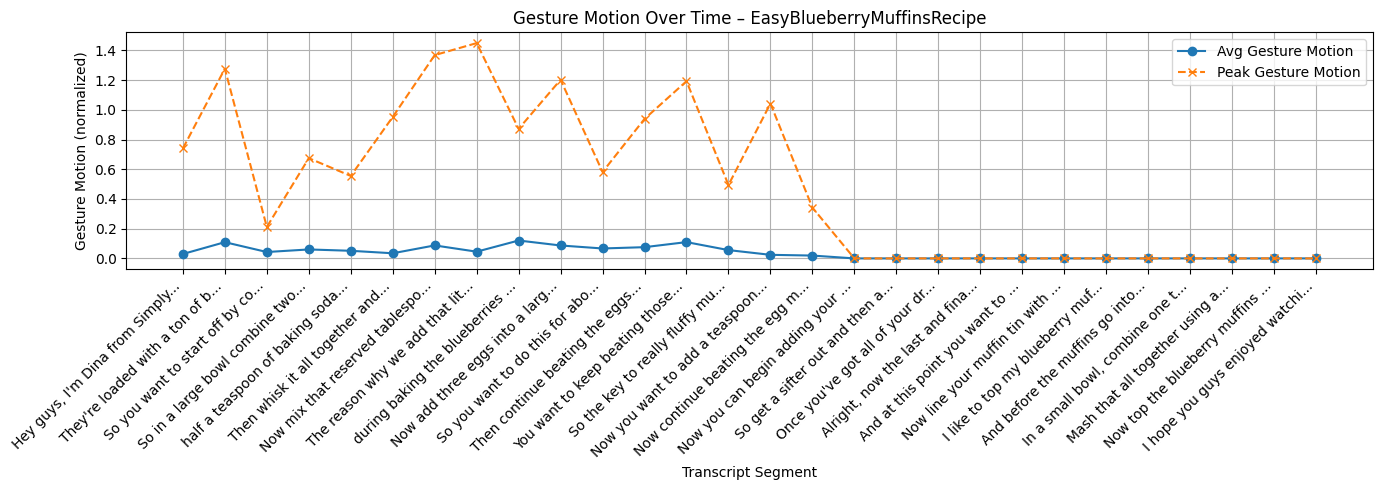

In [13]:
ALIGNED_DIR = "/workspaces/Gesture-Language-Alignment-in-Instructional-Videos/00_videos/aligned_transcripts"

def plot_gesture_motion(base_name):
    aligned_path = os.path.join(ALIGNED_DIR, f"{base_name}_aligned.json")

    if not os.path.exists(aligned_path):
        print(f"❌ File not found: {aligned_path}")
        return

    with open(aligned_path, "r") as f:
        data = json.load(f)

    if not data:
        print(f"No aligned data in {base_name}_aligned.json")
        return

    segments = [d["text"][:30] + "..." if len(d["text"]) > 30 else d["text"] for d in data]
    gesture_avg = [d["gesture_avg"] for d in data]
    gesture_peak = [d["gesture_peak"] for d in data]
    x = range(len(data))

    plt.figure(figsize=(14, 5))
    plt.plot(x, gesture_avg, label="Avg Gesture Motion", marker="o")
    plt.plot(x, gesture_peak, label="Peak Gesture Motion", marker="x", linestyle="--")
    plt.xticks(x, segments, rotation=45, ha="right")
    plt.xlabel("Transcript Segment")
    plt.ylabel("Gesture Motion (normalized)")
    plt.title(f"Gesture Motion Over Time – {base_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_gesture_motion("EasyBlueberryMuffinsRecipe")


In [12]:
ALIGNED_DIR = "/workspaces/Gesture-Language-Alignment-in-Instructional-Videos/00_videos/aligned_transcripts"

def highlight_high_motion_segments(base_name, threshold=0.02):
    aligned_path = os.path.join(ALIGNED_DIR, f"{base_name}_aligned.json")

    if not os.path.exists(aligned_path):
        print(f"File not found: {aligned_path}")
        return

    with open(aligned_path, "r") as f:
        data = json.load(f)

    print(f"\n🔍 Segments with avg motion > {threshold}:\n")
    for d in data:
        if d["gesture_avg"] > threshold:
            print(f"{d['start_time']:.1f}s–{d['end_time']:.1f}s: {d['text']} (avg={d['gesture_avg']:.3f})")

highlight_high_motion_segments("EasyBlueberryMuffinsRecipe", threshold=0.015)


🔍 Segments with avg motion > 0.015:

0.0s–7.1s: Hey guys, I'm Dina from SimplyHomeCook.com and today I'll be showing how to make these fluffy and moist blueberry muffins. (avg=0.030)
7.2s–13.2s: They're loaded with a ton of blueberries and they're topped the simple and delicious brown sugar streusel. (avg=0.109)
13.8s–16.6s: So you want to start off by combining all of your dry ingredients. (avg=0.043)
16.6s–22.0s: So in a large bowl combine two cups of all-purpose flour, a teaspoon of baking powder, (avg=0.060)
22.7s–26.6s: half a teaspoon of baking soda, and a quarter teaspoon of salt. (avg=0.051)
26.6s–31.8s: Then whisk it all together and reserve one tablespoon of that flour mixture. (avg=0.035)
34.0s–38.8s: Now mix that reserved tablespoon of the flour mixture with one and a half cups of fresh blueberries. (avg=0.087)
39.0s–44.0s: The reason why we add that little tiny bit of flour to those blueberries is when we add them to the batter, (avg=0.045)
44.4s–47.8s: during baking the 